In [252]:
## Load Libraries

import pandas as pd
import numpy as np
import os
import re
import pytz
import yfinance as yf
from dotenv import load_dotenv
import openai
from sklearn.cluster import KMeans
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import ast
from itertools import chain
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.schema.messages import HumanMessage, SystemMessage
from langchain.prompts import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    PromptTemplate,
    SystemMessagePromptTemplate,
)

pd.set_option("display.max_columns", 50)

In [2]:
## Load Company Data

corps = pd.read_csv("data/corps.csv")

industrials = pd.read_csv("data/corps/industrials.csv")
healthcare = pd.read_csv("data/corps/healthcare.csv")
finance = pd.read_csv("data/corps/finance.csv")
tech = pd.read_csv("data/corps/tech.csv")
consumer = pd.read_csv("data/corps/consumer.csv")
energy = pd.read_csv("data/corps/energy.csv")

In [75]:
## Load Cleaned Data

prices = pd.read_csv("data/industrials_073124/prices.csv", index_col=0)
news = pd.read_csv("data/industrials_073124/news.csv", index_col=0)

### **News Features**

In [4]:
freq = news.groupby("Ticker")["Ticker"].size().sort_values(ascending=False).reset_index(name="Count")

freq[freq["Count"]>100]

,Ticker,Count
0,BA,1155
1,EML,886
2,GORO,737
3,TISI,703
4,RS,685
...,...,...
78,HA,110
79,JCI,109
80,STCN,107
81,CBT,106


In [27]:
fast = news[news["Ticker"]=="FAST"].copy()
fast.head()

,Time,Ticker,Name,Heading,Subheading,Publisher,Found,Recency
1097,2024-06-20 15:30:00,FAST,Fastenal,"Laser Photonics Inks Deals With Brokk, Fastena...",and its laser-based solutions are changing the...,benzinga.com,2024-06-20 15:04:52,0 days 02:31:58
2253,2024-06-21 12:30:00,FAST,Fastenal,Fastenal's (FAST) Average Daily Sales Increase...,Fastenal Company FAST recently released its Ma...,sg.news.yahoo.com,2024-06-21 12:04:49,0 days 10:47:54
3758,2024-06-24 09:30:00,FAST,Fastenal,Fastenal Co. stock underperforms Friday when c...,Shares of Fastenal Co. inched 0.34% higher to ...,marketwatch.com,2024-06-22 13:04:47,0 days 16:07:43
4539,2024-06-24 09:30:00,FAST,Fastenal,Wedmont Private Capital Purchases 224 Shares o...,"Czech National Bank now owns 100,685 shares of...",defenseworld.net,2024-06-23 13:04:40,0 days 05:45:41
4540,2024-06-24 09:30:00,FAST,Fastenal,Fastenal (FAST) Gains But Lags Market: What Yo...,The PEG ratio is similar to the widely-used P/...,nz.news.yahoo.com,2024-06-23 13:04:40,0 days 11:19:32


In [43]:
## Publisher Frequency

freq = news.groupby("Publisher")["Publisher"].size() \
    .reset_index(name="Count").sort_values("Count", ascending=False)

In [60]:
## Publisher Effect

pnews = pd.merge(news, prices[["Time", "Ticker", "Delta+1"]], how="left", on=["Time", "Ticker"])
pnews_pos = pnews[pnews["Delta+1"]>0]
pnews_neg = pnews[pnews["Delta+1"]<0]
pnews["Abs_Delta+1"] = pnews["Delta+1"].abs()
effect = pnews.groupby("Publisher")["Abs_Delta+1"].mean() \
    .reset_index(name="Effect").sort_values("Effect", ascending=False)
effect_pos = pnews_pos.groupby("Publisher")["Delta+1"].mean() \
    .reset_index(name="Effect").sort_values("Effect", ascending=False)
effect_neg = pnews_neg.groupby("Publisher")["Delta+1"].mean() \
    .reset_index(name="Effect").sort_values("Effect", ascending=True)

In [67]:
top_neg_pubs = pd.merge(freq[freq["Count"]>50], effect_neg, how="left", on="Publisher") \
    .sort_values("Effect", ascending=True).head(50)["Publisher"].values.tolist()

top_pos_pubs = pd.merge(freq[freq["Count"]>50], effect_pos, how="left", on="Publisher") \
    .sort_values("Effect", ascending=False).head(50)["Publisher"].values.tolist()

In [76]:
news["TNP"] = np.where(news["Publisher"].isin(top_neg_pubs), 1, 0)
news["TPP"] = np.where(news["Publisher"].isin(top_pos_pubs), 1, 0)

In [177]:
news[news["Ticker"]=="LIN"]["Subheading"][:50].values.tolist()

['Founded in 2017, UK-based Linde Plc is a leading global industrial gases and engineering company. The company serves a variety of end markets ...',
 "In a report released yesterday, Michael Sison from Wells Fargo assigned a Buy rating to Linde, with a price target of $540.00. The company's shares ...",
 'Last year, Linde Bangladesh demerged its hard goods business such as welding products and equipment to a wholly owned subsidiary company. The ...',
 'According to the company, it will be the first of its kind. The project is named Capture-to-Use (CAP2U) and will capture 70,000t/yr of CO₂ ...',
 "The demerger is part of Linde's strategy to create more focus on its gas business, according to a company official. Now, the company is going to sell ...",
 'The company paid a 420 per cent cash dividend to shareholders for 2022. In a stock exchange filing, Linde said it announced the dividend based on the ...',
 "In a report released yesterday, John McNulty from BMO Capital reiterated a Buy 

### **Embeddings**

In [339]:
## Create Batches

#############
size = 1000
#############

data = [
    f"{row['Heading']} | {row['Subheading']}"
    for idx, row in news.iterrows()]
batches = []
while len(data) > size:
    batches.append(data[0:size])
    data = data[size:]
batches.append(data)

In [348]:
## Create Embeddings

###################
# batch_number = 2
###################

# Batches 3-9

for batch_number in range(3, 10):

    batch = batches[batch_number-1]

    load_dotenv()
    api_key = os.getenv('OPENAI_API_KEY')

    oai = openai.OpenAI(
        api_key=api_key,
    )

    def get_embedding(text_to_embed, openai):
        response = openai.embeddings.create(
            model= "text-embedding-3-large",
            input=[text_to_embed]
        )
        return response.data[0].embedding

    def normalize_l2(x):
        x = np.array(x)
        if x.ndim == 1:
            norm = np.linalg.norm(x)
            if norm == 0:
                return x
            return x / norm
        else:
            norm = np.linalg.norm(x, 2, axis=1, keepdims=True)
            return np.where(norm == 0, x, x / norm)

    embeddings_1024 = []
    for heading in batch:
        emb = get_embedding(heading, oai)
        cut_dim = emb[:1024]
        norm_dim = normalize_l2(cut_dim)
        embeddings_1024.append(norm_dim)

    embeddings_array = np.array(embeddings_1024)
    np.save(f"data/embeddings/batch_{batch_number}.npy", embeddings_array)

In [206]:
## Load d256 Embeddings

total_batches = 2
embeddings_all = []

for n in range(0, total_batches):
    embeddings_1024 = np.load(f"data/embeddings/batch_{n+1}.npy")
    for emb in embeddings_1024:
        cut_dim = emb[:256]
        norm_dim = normalize_l2(cut_dim)
        embeddings_all.append(norm_dim)
    del embeddings_1024

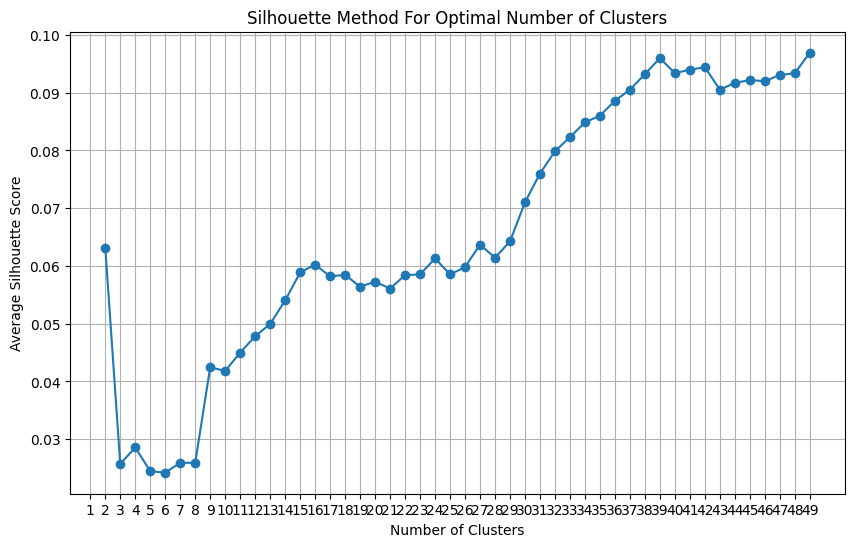

In [235]:
## K-Means Clustering

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    n = 50

    range_n_clusters = range(2, n)
    silhouette_avg = []

    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(embeddings_all)
        silhouette_avg.append(silhouette_score(embeddings_all, cluster_labels))

    plt.figure(figsize=(10, 6))
    plt.plot(range_n_clusters, silhouette_avg, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Average Silhouette Score')
    plt.title('Silhouette Method For Optimal Number of Clusters')
    plt.xticks(range(1, n))
    plt.grid(True)
    plt.show()

In [11]:
## Select Optimal Number of Clusters

optimal_n_clusters = 32

kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=1)
kmeans.fit(embeddings_all)
labels = kmeans.labels_

dict_labels = {heading: label for heading, label in zip(headings_list, labels)}

In [12]:
fast["Heading_Cluster"] = fast["Heading"].map(dict_labels)

### **GPT Impact Score**

In [304]:
## Create news event impact score feature

prompt_intro = """
Forget all your previous instructions. You are a financial expert with stock recommendation experience.
Your job is to predict whether a news event will have a positive, negative, or negligible impact on the
price of a specified company's stock within the next day. Do not worry if some news events are similar;
score them similarly. Here are the different scores you can give for each news event, based on your
judgment of how it will impact the next day's stock price for the specified company:

3: strong positive impact
2: moderate positive impact
1: slight positive impact
0: little to no impact
-1: slight negative impact
-2: moderate negative impact
-3: strong negative impact

Here is some general guidance:
* Disruptions in company production, fines, admissions of misconduct, or lawsuits against the company should be scored negatively
* New deals, partnerships, expansions, or product launches should be scored positively
* News events unrelated to the company should be scored 0
* News events that do not convey meaningful information should be scored 0
* Announcements of financial results WITHOUT information on whether the results were good or bad should be scored 0
* Announcements that sound like advertisements or anecdotes and are unrelated to the financial performance of the company should be scored 0
* Analyst opinion pieces should never be scored above 1 or below -1, because they are not breaking news
* If you believe it to be justified, you can use your best judgment to override any of the above guidelines

I will pass data on each news event as separate lines. The data for each news event will have different
elements associated with it, which will be separated by commas. Here are descriptions for the different
elements:

ID: <the id of the news event, across all companies, which starts at 0>
Company: <the company whose stock price is being predicted by the headline>
Heading: <the news headline itself>
Subheading: <the subheading that follows the news headline>

The structure of the input will look like this:

<news event 1>
<news event 2>
<news event 3>

For each news event, please return ONLY the ID of the news event and the impact score you decided on as a Python dictionary
like this: {ID: Score, ID: Score, ID: Score}
The ID you return for each news event should be the same ID provided in the input.

Do not respond with ANYTHING else except the dictionary of IDs and scores. The length of the dictionary
should be equal to the number of news events that I ask you to analyze. Do not insert a new line after
each dictionary entry. See below for an example.

EXAMPLE INPUT:
ID: 0, Company: Tesla, Heading: Tesla Doubles Sales of Newest EV, Subheading: Tesla announced today that it has doubled sales of its newest electric vehicle ...
ID: 1, Company: Tesla, Heading: Tesla Says Fine from SEC Likely, Subheading: Tesla disclosed today that it believes that it will be fined by the SEC in the coming year...
ID: 2, Company: Tesla, Heading: Tesla to Host Earnings Call Next Week, Subheading: Tesla announced today that it will be hosting its quarterly earnings call next week ...

EXAMPLE OUTPUT:
{0: 2, 1: -2, 2: 0}

Okay, analyze the real input below and give me your answer:
\n
"""



In [298]:
#################
batch_size = 10
unit_size = 100
#################

data = [
    f"ID: {idx}, Company: {row['Name']}, Heading: {row['Heading']}, Subheading: {row['Subheading']}"
    for idx, row in news.iterrows()]

units = []
while len(data) > unit_size:
    units.append(data[:unit_size])
    data = data[unit_size:]
if data:
    units.append(data)

batches = []
for i in range(0, len(units), batch_size):
    batch = units[i:i + batch_size]
    batches.append(batch)

In [310]:
len(batches)

35

In [335]:
# Batches 30-35

for batch_number in range(30, 36):

    batch = batches[batch_number-1]

    def ask(user_query):
            chat_model = ChatOpenAI(model="gpt-4o", temperature=0)
            response = chat_model.invoke(user_query).content
            return response

    outputs_batch = {}
    for unit in batch:
        prompt = prompt_intro + f"\n".join(unit)
        text = ask(prompt)
        output_raw = text[text.find("{"):text.find("}")+1]
        output = ast.literal_eval(output_raw)
        output = {int(k):float(v) for k, v in output.items()}
        outputs_batch.update(output)

    ids = [int(re.search(r'ID: (\d+)', text).group(1)) for text in list(chain.from_iterable(batch))
        if re.search(r'ID: (\d+)', text)]
    df = news.loc[ids]
    df["Impact_Score"] = df.index.map(outputs_batch)
    df.to_csv(f"data/gpt/batch_{batch_number}.csv")

### **Create Modeling Table**

In [232]:
## Create Modeling Table

news_df = news

news1 = news_df.groupby(["Time", "Ticker"]).agg({
    "Heading": list,
    "Subheading": list,
    "Publisher": list,
    "TNP": list,
    "TPP": list,
    "Found": list,
    "Recency": list
}).reset_index()

modeling = pd.merge(prices, news1,
         on=["Time", "Ticker"],
         how="left").fillna("")

modeling["Headlines_Cnt"] = modeling["Heading"].apply(len)
modeling["TNP_Cnt"] = modeling["TNP"].apply(sum)
modeling["TPP_Cnt"] = modeling["TPP"].apply(sum)
modeling["ID"] = modeling["Ticker"] + "-" + [x.replace(" ", "-")[5:-3] for x in modeling["Time"].astype(str)]
modeling["Hour"] = [x[11:-3] for x in modeling["Time"].astype(str)]

modeling1 = modeling[modeling["Headlines_Cnt"]>0][["ID", "Time", "Delta+1", "Hour", "Company", "Sector", "Cap",
                        "Open-1", "High-1", "Low-1", "Delta-1", "Open_Diff", "Volume-1",
                        "Dividends-1", "Stock_Splits-1",
                        "Heading", "Subheading", "Publisher", "Found", "Recency",
                        "TNP", "TPP", "TNP_Cnt", "TPP_Cnt",
                        "Headlines_Cnt"]].copy()

modeling1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10190 entries, 84 to 125548
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              10190 non-null  object 
 1   Time            10190 non-null  object 
 2   Delta+1         10190 non-null  float64
 3   Hour            10190 non-null  object 
 4   Company         10190 non-null  object 
 5   Sector          10190 non-null  object 
 6   Cap             10190 non-null  float64
 7   Open-1          10190 non-null  float64
 8   High-1          10190 non-null  float64
 9   Low-1           10190 non-null  float64
 10  Delta-1         10190 non-null  float64
 11  Open_Diff       10190 non-null  float64
 12  Volume-1        10190 non-null  int64  
 13  Dividends-1     10190 non-null  float64
 14  Stock_Splits-1  10190 non-null  float64
 15  Heading         10190 non-null  object 
 16  Subheading      10190 non-null  object 
 17  Publisher       10190 non-null  ob

In [233]:
# How to condense embedding information within time intervals?
    # Weighted averaging of most important headlines
    # Non

modeling1

,ID,Time,Delta+1,Hour,Company,Sector,Cap,Open-1,High-1,Low-1,Delta-1,Open_Diff,Volume-1,Dividends-1,Stock_Splits-1,Heading,Subheading,Publisher,Found,Recency,TNP,TPP,TNP_Cnt,TPP_Cnt,Headlines_Cnt
84,LIN-06-20-09:30,2024-06-20 09:30:00,0.037292,09:30,Linde,Basic Materials,206652.0,440.220001,0.063604,-0.181725,0.006814,-0.265761,152558,0.0,0.0,[Linde (LIN) Receives a Hold from UBS | Market...,"[Founded in 2017, UK-based Linde Plc is a lead...","[markets.businessinsider.com, markets.business...","[2024-06-19 23:08:06, 2024-06-19 23:08:06]","[0 days 13:47:24, 0 days 11:56:30]","[1, 1]","[1, 1]",2,2,2
90,LIN-06-20-15:30,2024-06-20 15:30:00,-0.387912,15:30,Linde,Basic Materials,206652.0,443.820007,0.058578,-0.290660,-0.109846,-0.072740,142752,0.0,0.0,[Linde BD declares record 1540pc interim cash ...,"[Last year, Linde Bangladesh demerged its hard...","[observerbd.com, globalcement.com, tbsnews.net...","[2024-06-20 15:08:16, 2024-06-20 15:08:16, 202...","[0 days 04:07:32, 0 days 02:38:22, 0 days 02:5...","[0, 0, 0, 0, 1, 0, 1]","[0, 0, 0, 0, 1, 0, 0]",2,1,7
98,LIN-06-24-09:30,2024-06-24 09:30:00,0.214003,09:30,Linde,Basic Materials,206652.0,441.519989,0.484693,0.000000,0.260469,0.467612,244964,0.0,0.0,"[Linde sells forklift unit Kion to KKR, Goldma...",[German industrial gases firm Linde <LING.DE> ...,"[reuters.com, courant.com, chemengonline.com, ...","[2024-06-22 00:08:12, 2024-06-22 00:08:12, 202...","[0 days 15:27:01, 0 days 14:22:55, 0 days 10:1...","[1, 0, 0, 0, 0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0]",2,0,8
104,LIN-06-24-15:30,2024-06-24 15:30:00,-0.185983,15:30,Linde,Basic Materials,206652.0,442.839996,0.108394,-0.119682,-0.101613,-0.011306,84734,0.0,0.0,"[Linde, Heidelberg Materials Break Ground On G...","[The project, known as “Capture-to-Use” (CAP2U...","[carbonherald.com, beaumontenterprise.com, def...","[2024-06-24 15:08:11, 2024-06-24 15:08:11, 202...","[0 days 03:36:27, 0 days 05:56:33, 0 days 12:3...","[0, 0, 0, 0, 0]","[0, 0, 0, 1, 0]",0,1,5
105,LIN-06-25-09:30,2024-06-25 09:30:00,-0.281123,09:30,Linde,Basic Materials,206652.0,442.339996,0.291633,-0.045210,0.187642,0.092509,209460,0.0,0.0,[Airgas to buy Linde bulk gas unit for $495 ml...,[The U.S. Federal Trade Commission required Li...,"[reuters.com, defenseworld.net]","[2024-06-24 19:07:59, 2024-06-25 08:08:11]","[0 days 03:54:37, 0 days 21:26:48]","[1, 0]","[0, 0]",1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125291,WWR-07-18-14:30,2024-07-18 14:30:00,-2.172566,14:30,Westwater Resources,Basic Materials,27.0,0.527600,0.037914,-1.156179,-1.137222,0.306742,12130,0.0,0.0,[Westwater Resources Announces Update to Confe...,"[CENTENNIAL, Colo., July 17, 2024--Westwater R...","[youtube.com, quantisnow.com, businesswire.com...","[2024-07-18 14:14:29, 2024-07-18 14:14:29, 202...","[0 days 01:16:30, 0 days 01:57:32, 0 days 14:5...","[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]","[0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]",10,9,11
125300,WWR-07-22-09:30,2024-07-22 09:30:00,0.229977,09:30,Westwater Resources,Basic Materials,27.0,0.516900,1.924934,-0.793195,1.924934,5.343081,13294,0.0,0.0,[Stellantis signs an agreement with Westwater ...,"[Westwater Resources, a company specializing i...","[proactiveinvestors.com, seekingalpha.com, cit...","[2024-07-20 15:14:10, 2024-07-20 15:14:10, 202...","[0 days 07:12:47, 0 days 14:57:14, 1 days 14:2...","[0, 1, 0]","[0, 1, 0]",1,1,3
125517,SIF-06-20-09:30,2024-06-20 09:30:00,-0.156254,09:30,SIFCO Industries,Industrials,20.0,3.200000,0.000000,0.000000,0.000000,-0.624999,574,0.0,0.0,[SIFCO Industries (NYSE:SIF) Earns Buy Rating ...,"[About SIFCO Industries ... SIFCO Industries, ...",[defenseworld.net],[2024-06-20 03:11:51],[0 days 21:44:01],[0],[0],0,0,1
125545,SIF-07-01-09:30,2024-07-01 09:30:00,-0.156254,09:30,SIFCO Industries,Industrials,20.0,3.100000,0.000000,0.000000,0.000000,3.225811,124,0.0,0.0,[SIFCO names George Scherff as CEO (NYSE:SIF) ...,[SIFCO Industries (NYSE:SIF) on Friday announc..